# Speech Emotion Recognition Project

In [1]:
import numpy as np
import pandas as pa
import seaborn as sea
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
import librosa
import librosa.display
import sys
import os
import glob
import soundfile as sf

In [3]:
import glob

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [5]:
from IPython.display import Audio


In [6]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [7]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

## loading dataset

In [8]:
RavdeesData="audio_speech_actors_01-24\\"

In [9]:
rdl=os.listdir(RavdeesData)
fileEmotion=[]
filePath=[]
for dir in rdl:
    actor=os.listdir(RavdeesData+dir)
    for file in actor:
        part=file.split('.')[0]
        part=part.split('-')
        fileEmotion.append(int(part[2]))
        filePath.append(RavdeesData+dir+'/'+file)
emotion_df=pa.DataFrame(fileEmotion,columns=['Emotions'])
path_df=pa.DataFrame(filePath,columns=['Path'])
Ravdees_df=pa.concat([emotion_df,path_df],axis=1)

### Replacing data in dataframe

In [10]:
Ravdees_df.Emotions.replace({1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fear',7:'disgust',8:'surprise'},inplace=True)

### Display top 5 rows of the dataframe using head method

In [11]:
Ravdees_df.head()

,Emotions,Path
0,neutral,audio_speech_actors_01-24\Actor_01/03-01-01-01...
1,neutral,audio_speech_actors_01-24\Actor_01/03-01-01-01...
2,neutral,audio_speech_actors_01-24\Actor_01/03-01-01-01...
3,neutral,audio_speech_actors_01-24\Actor_01/03-01-01-01...
4,calm,audio_speech_actors_01-24\Actor_01/03-01-02-01...


### Display last 5 rows of the dataframe using tail method

In [12]:
Ravdees_df.tail()

,Emotions,Path
1435,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-01...
1436,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-02...
1437,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-02...
1438,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-02...
1439,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-02...


### Display shape of the dataframe using shape attribute

In [13]:
Ravdees_df.shape

(1440, 2)

### Display count of the Emotions column

In [14]:
Ravdees_df['Emotions'].value_counts()

surprise    192
angry       192
calm        192
sad         192
fear        192
disgust     192
happy       192
neutral      96
Name: Emotions, dtype: int64

In [15]:
dataPath=pa.concat([Ravdees_df],axis=0)
dataPath.to_csv("data_path.csv",index=False)
dataPath.head()

,Emotions,Path
0,neutral,audio_speech_actors_01-24\Actor_01/03-01-01-01...
1,neutral,audio_speech_actors_01-24\Actor_01/03-01-01-01...
2,neutral,audio_speech_actors_01-24\Actor_01/03-01-01-01...
3,neutral,audio_speech_actors_01-24\Actor_01/03-01-01-01...
4,calm,audio_speech_actors_01-24\Actor_01/03-01-02-01...


In [16]:
dataPath.tail()

,Emotions,Path
1435,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-01...
1436,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-02...
1437,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-02...
1438,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-02...
1439,surprise,audio_speech_actors_01-24\Actor_24/03-01-08-02...


In [17]:
dataPath['Emotions']=dataPath['Emotions'].astype('category')
dataPath.Emotions

0        neutral
1        neutral
2        neutral
3        neutral
4           calm
          ...   
1435    surprise
1436    surprise
1437    surprise
1438    surprise
1439    surprise
Name: Emotions, Length: 1440, dtype: category
Categories (8, object): ['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [18]:
label_encoder=LabelEncoder()
dataPath['Emotions_encoded']=label_encoder.fit_transform(dataPath['Emotions'])


In [19]:
dataPath['Emotions_encoded']

0       5
1       5
2       5
3       5
4       1
       ..
1435    7
1436    7
1437    7
1438    7
1439    7
Name: Emotions_encoded, Length: 1440, dtype: int32

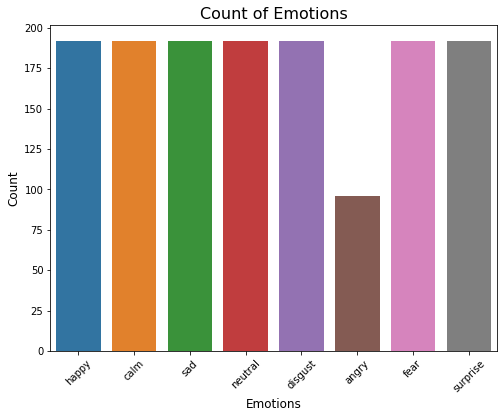

In [20]:
unique_encoded=dataPath['Emotions_encoded'].unique()
label_encoder.classes_=sorted(label_encoder.classes_)
dataPath['Emotions_encoded'] = dataPath['Emotions_encoded'].astype('category')
plt.figure(figsize=(8,6))
sea.countplot(data=dataPath,x='Emotions_encoded')
plt.title('Count of Emotions',size=16)
plt.ylabel('Count',size=12)
plt.xlabel('Emotions',size=12)
plt.xticks(ticks=unique_encoded,labels=label_encoder.classes_,rotation=45)
plt.show()

In [21]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

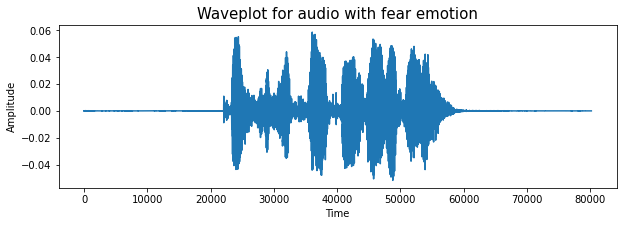

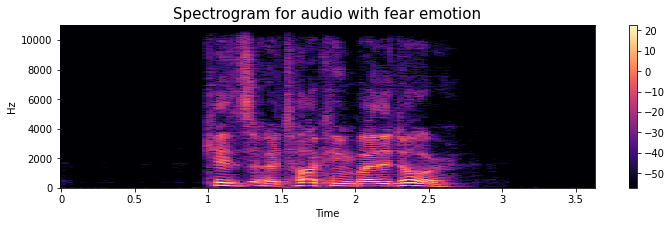

In [22]:
emotion='fear'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

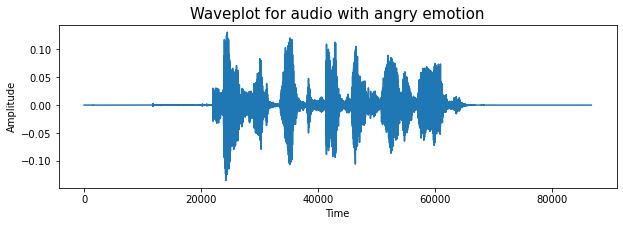

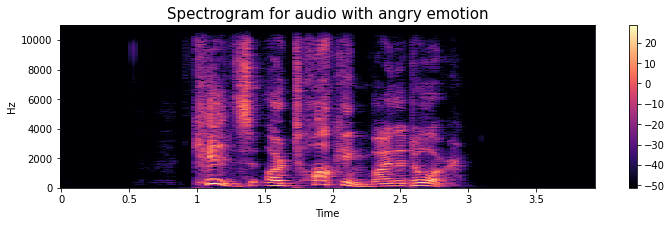

In [23]:
emotion='angry'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


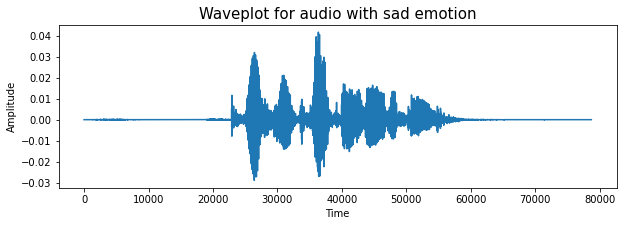

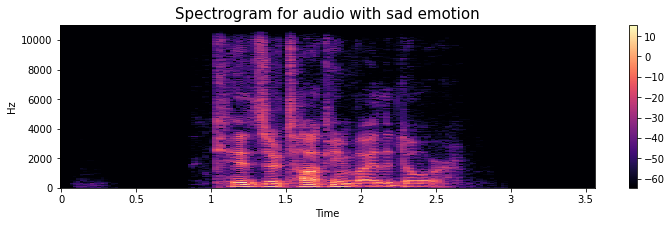

In [24]:
emotion='sad'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

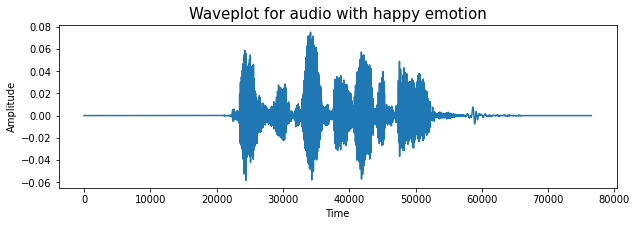

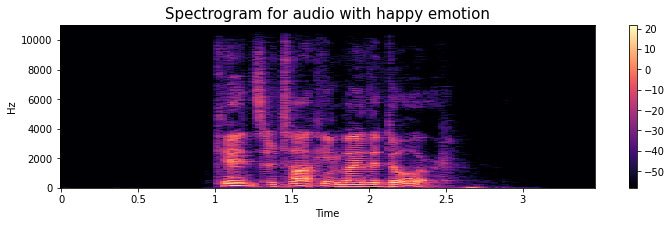

In [25]:
emotion='happy'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


In [26]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    rate=0.5
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(dataPath.Path)[1]
data, sample_rate = librosa.load(path)

<Figure size 1008x288 with 0 Axes>

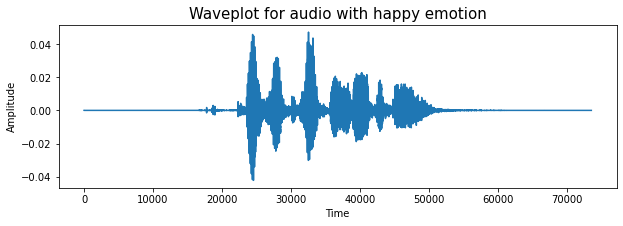

In [27]:
x = noise(data)
plt.figure(figsize=(14,4))
create_waveplot(data,sample_rate,emotion)
Audio(x, rate=sample_rate)

Stretched data shape: (147148,)
Stretched data type: <class 'numpy.ndarray'>


<Figure size 1008x288 with 0 Axes>

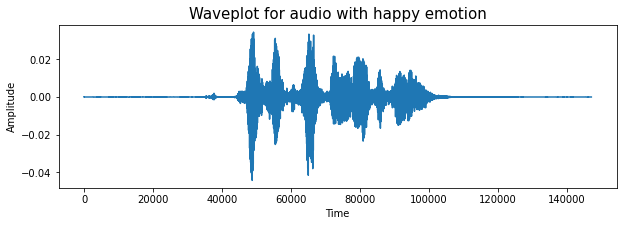

In [28]:
x = stretch(data)
print("Stretched data shape:",x.shape)
print("Stretched data type:",type(x))
plt.figure(figsize=(14,4))
create_waveplot(x,sample_rate,emotion)
Audio(x, rate=sample_rate)

<Figure size 1008x288 with 0 Axes>

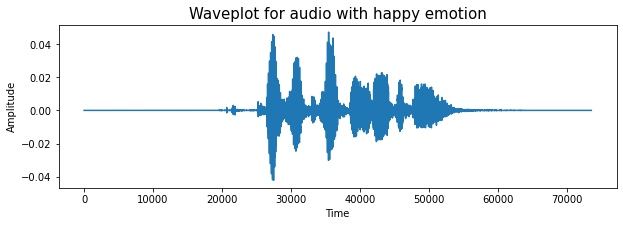

In [29]:
x = shift(data)
plt.figure(figsize=(14,4))
create_waveplot(x,sample_rate,emotion)
Audio(x, rate=sample_rate)

<Figure size 1008x288 with 0 Axes>

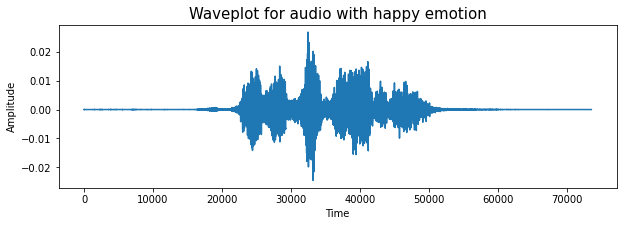

In [30]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
create_waveplot(x,sample_rate,emotion)

Audio(x, rate=sample_rate)

## extracting features

In [31]:
def extract_features(data):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))
    
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))
    
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))
    
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))
    
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features(path)
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    res1 = extract_features(data)
    result = np.array(res1)
    
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 
    
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) 
    
    return result

In [32]:
X, Y = [], []
for path, emotion in zip(dataPath.Path, dataPath.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)


In [33]:
len(X), len(Y), dataPath.Path.shape

(4320, 4320, (1440,))

In [34]:
Features = pa.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.283226,0.739174,0.760110,0.738748,0.712194,0.687986,0.667279,0.694000,0.742275,0.762594,...,0.000004,0.000003,0.000002,0.000002,4.562520e-06,4.985616e-06,1.324619e-06,1.469305e-07,3.053402e-09,neutral
1,0.327180,0.812937,0.835850,0.821803,0.829319,0.820569,0.716820,0.698424,0.733311,0.769402,...,0.000083,0.000082,0.000089,0.000083,8.524698e-05,8.711231e-05,8.247586e-05,8.244806e-05,8.351164e-05,neutral
2,0.169248,0.682738,0.732715,0.711501,0.683272,0.679657,0.661524,0.659021,0.717842,0.775657,...,0.000001,0.000002,0.000001,0.000001,5.355230e-07,6.928516e-07,3.275288e-07,2.201797e-08,1.727055e-10,neutral
3,0.254530,0.676571,0.724970,0.725722,0.668644,0.645344,0.671471,0.631493,0.681749,0.709889,...,0.000007,0.000007,0.000007,0.000007,1.117492e-05,5.767251e-06,2.024577e-06,1.944936e-07,2.701240e-09,neutral
4,0.291545,0.738009,0.780913,0.794326,0.751793,0.754362,0.742458,0.646483,0.678468,0.718811,...,0.000026,0.000027,0.000026,0.000025,2.792202e-05,2.250444e-05,2.060204e-05,1.915020e-05,1.844990e-05,neutral


In [35]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [36]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [38]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [39]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [40]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [42]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 13s 226ms/step - loss: 1.9972 - accuracy: 0.1960 - val_loss: 1.9285 - val_accuracy: 0.2111
Epoch 2/50
51/51 [==============================] - 12s 232ms/step - loss: 1.9501 - accuracy: 0.2185 - val_loss: 1.8567 - val_accuracy: 0.2713
Epoch 3/50
51/51 [==============================] - 11s 218ms/step - loss: 1.8814 - accuracy: 0.2367 - val_loss: 1.7905 - val_accuracy: 0.3130
Epoch 4/50
51/51 [==============================] - 11s 220ms/step - loss: 1.8325 - accuracy: 0.2664 - val_loss: 1.7321 - val_accuracy: 0.3269
Epoch 5/50
51/51 [==============================] - 12s 231ms/step - loss: 1.7776 - accuracy: 0.3102 - val_loss: 1.6656 - val_accuracy: 0.3991
Epoch 6/50
51/51 [==============================] - 12s 235ms/step - loss: 1.7436 - accuracy: 0.3173 - val_loss: 1.6540 - val_accuracy: 0.3843
Epoch 7/50
51/51 [==============================] - 11s 221ms/step - loss: 1.7059 - accuracy: 0.3522 - val_loss: 1.6278 - val_accuracy: 0.3731

34/34 [==============================] - 1s 30ms/step - loss: 1.4046 - accuracy: 0.6694
Accuracy of our model on test data :  66.94444417953491 %


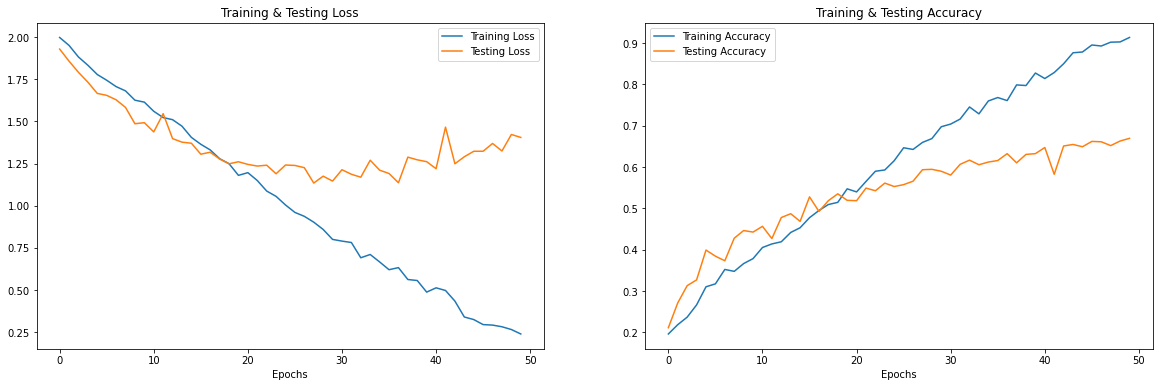

In [43]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [44]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [46]:
df = pa.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,happy,angry
2,fear,fear
3,neutral,calm
4,happy,angry
5,surprise,surprise
6,fear,fear
7,fear,happy
8,fear,fear
9,sad,sad


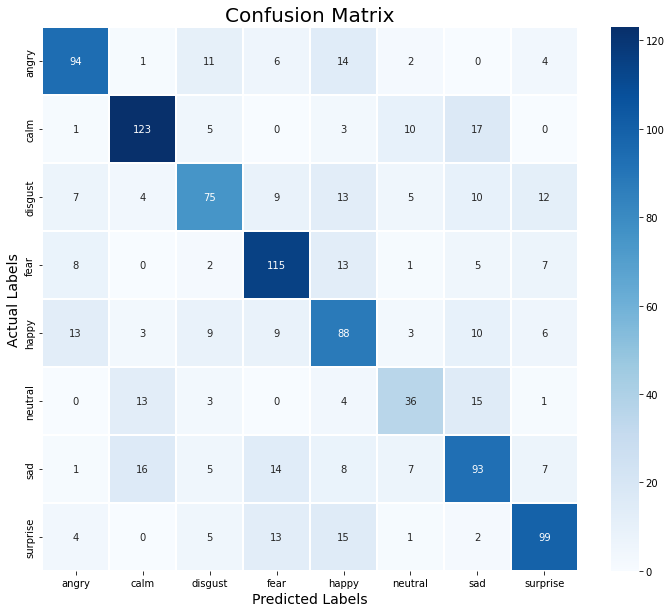

In [49]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pa.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sea.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.73      0.71      0.72       132
        calm       0.77      0.77      0.77       159
     disgust       0.65      0.56      0.60       135
        fear       0.69      0.76      0.73       151
       happy       0.56      0.62      0.59       141
     neutral       0.55      0.50      0.53        72
         sad       0.61      0.62      0.61       151
    surprise       0.73      0.71      0.72       139

    accuracy                           0.67      1080
   macro avg       0.66      0.66      0.66      1080
weighted avg       0.67      0.67      0.67      1080

